In [31]:
import numpy as np
import torch

from torch.autograd import Variable
from models.gan import GAN

# Visualization imports
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from scipy.stats import norm


First, we create the data distribution that we are going to learn. We start with a sample from a one-dimensional uniform distribution:


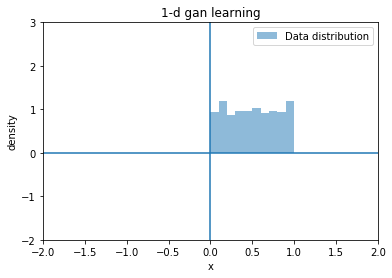

In [2]:
data = torch.cat([torch.rand((1000, 1))]) # a simple 1-d uniform distribution

# For a multimodal distribution, uncomment the line below
#data = torch.cat([torch.rand((1000, 1))/2 - 0.5,  torch.rand((1000, 1))/2 + 0.5, torch.rand((1000, 1))/2 + 1.5])

def plot_data(data):

    fig, ax = plt.subplots()
    hist = ax.hist(data.numpy(), density=True, label="Data distribution", alpha=0.5)

    _ = ax.set_title("1-d gan learning")
    _ = ax.set_xlabel("x")
    _ = ax.set_ylabel("density")
    _ = ax.set_xlim(-2, 2)
    _ = ax.set_ylim(-2, 3)
    _ = ax.axhline(y=0)
    _ = ax.legend()
    _ = ax.axvline(0)
    return ax, fig

ax, fig = plot_data(data)


Now, on the bottom, we could add a shape of the latent space distribution that our generator gets samples from. We could start with a simple 1-d normal distribution.

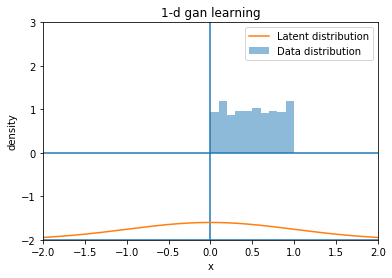

In [3]:
def add_latent_distrn(ax, pdf, N=1000, offset=2):
    low, high = ax.get_xlim()
    xs = np.linspace(low, high, N)
    ys = pdf(xs)
    
    ax.axhline(-offset)
    ax.plot(xs, ys-offset, label="Latent distribution")
    ax.legend()

ax, fig = plot_data(data)
add_latent_distrn(ax, norm.pdf)


Now we can create our GAN: we first initialize our discriminator and generator networks, and then pass them as parameters to the GAN model.

In [4]:
   
latent_dim = 1 # Latent space dimension
batch_size = 25
hidden_size = 500

generator = torch.nn.Sequential(
    torch.nn.Linear(latent_dim, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, data.shape[1]),
)

discriminator = torch.nn.Sequential(
    torch.nn.Linear(data.shape[1], hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, 1),
    torch.nn.Sigmoid()
)

optim_generator = torch.optim.Adam
optim_discriminator = torch.optim.Adam

gan = GAN(generator, discriminator, optim_generator, optim_discriminator, latent_dim, batch_size)

To see what are the gan is doing, we could sample from the model before training and add this histogram to our plot.

We could also query the discriminator for all possible 1-d input points, to see what is its decision 

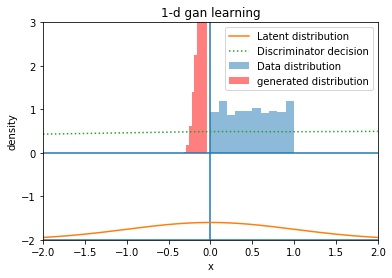

In [5]:
def add_generated_distrn(gan, ax, N=10000):
    generated_sample = gan.generate(N).data.numpy()
    ax.hist(generated_sample, label="generated distribution", color="red", alpha=0.5, density=True)
    ax.legend()

def add_discriminator_predictions(gan, ax, N=1000):
    '''Get discriminator predictions for every point in X-space
       N is the number of points queried, low and high are the limits of interest.
    '''
    low, high = ax.get_xlim()
    xs = Variable(torch.FloatTensor(np.linspace(low, high, N).reshape(N, 1)))
    preds = gan.decide(xs)
    xs, ys = xs.data.numpy(), preds.data.numpy()
    ax.plot(xs, ys, label="Discriminator decision", linestyle=":")
    ax.legend()

ax, fig = plot_data(data)
add_latent_distrn(ax, norm.pdf)
add_generated_distrn(gan, ax)
add_discriminator_predictions(gan, ax)

As we see, initially the gan generates a distribution that, looks roughly normal. It is not surprising, since you would usually get a normal distribution if you sum a large number of random variables, which we do after our network gets its weights randomly initialized. The fact that it is off-centered is most likely due to the mechanics of bias initialization, but I need to look deeper into that.

### Adding fancy generator visulazation

Our plot already looks nice and fancy (according to my bad taste, at least), but there is definitely one more way to leverage the 1-d nature of our toy example. We coud directly visualize a mapping that our generator has learned. It was schematically done in the oririnal GAN paper, but now it would be a real model, as opposed to a simple illustration.

In [6]:
def add_generator_mapping(ax, gan, N=20, offset=2):
    low, high = ax.get_xlim()
    original = Variable(torch.FloatTensor(np.linspace(low, high, N).reshape(N, 1)))
    mapped = gan.generator.forward(original)
    original, mapped = original.data.numpy().ravel(), mapped.data.numpy().ravel()
    
    bases_x = original
    bases_y = np.full_like(original, -offset) 
    
    dx_vec = mapped - original
    dy_vec = np.full_like(original, offset) 
    
    for x, y, dx, dy in zip(bases_x, bases_y, dx_vec, dy_vec):
        ax.arrow(x, y, dx, dy)   
    

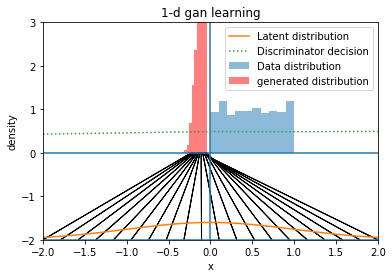

In [7]:
## Putting it all together
def plot_1d_gan(data, gan):
    ax, fig = plot_data(data)
    add_latent_distrn(ax, norm.pdf)
    add_generated_distrn(gan, ax)
    add_discriminator_predictions(gan, ax)
    add_generator_mapping(ax, gan)
    return ax, fig

ax, fig = plot_1d_gan(data, gan)

## Let the fun begin!

I hope you know where it is going. It is no fun to just look at this nice picture, so let's make it more alive!

Saved 1 plots
Saved 101 plots
Saved 201 plots
Saved 301 plots
Saved 401 plots
Saved 501 plots
Saved 601 plots
Saved 701 plots
Saved 801 plots
Saved 901 plots


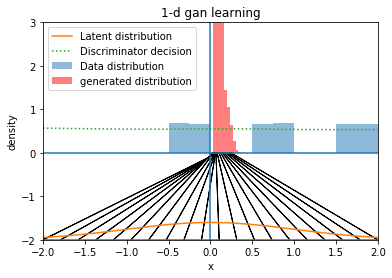

In [49]:
path = "./visuals/gan_1D_learning_multimodal/{}"
# Save original state:

plot_1d_gan(data, gan)
plt.savefig(path.format(0))

# Train and save the progress
for i in range(1000):
    if not i % 100:
        print("Saved {} plots".format(i + 1))

    vals = gan.train(data, 1, verbose=False) # Train for one update
    plot_1d_gan(data, gan)
    plt.savefig(path.format(i + 1))
    plt.close()
#plt.figure("Game Values")
#plt.plot(vals)
#plt.show()



# Moving to 2D

Now let's see, how the situation would look in 2D

First, let's create our new data: five clusters of normal random variables.

In [8]:
data = None
n_clusters = 5
r = 5

for phi in [2 * np.pi / n_clusters * i for i in range(5)]:
    tmp = torch.randn((1000, 2))
    tmp[:, 0] += np.cos(phi) * r
    tmp[:, 1] += np.sin(phi) * r
    
    if data is None:
        data = tmp
    else:
        data = torch.cat([data, tmp])

Let's take a look at the data:

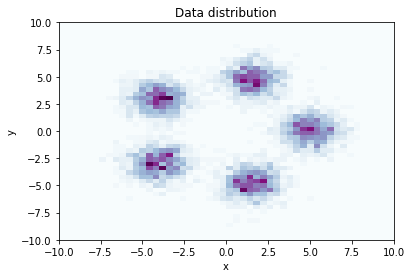

In [9]:
fig, ax = plt.subplots()
x, y = data.numpy()[:, 0], data.numpy()[:, 1]

ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))

xmin, xmax, ymin, ymax = -10, 10, -10, 10

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Data distribution")

counts, ybins, xbins, image = ax.hist2d(x, y, bins=(50, 50), cmap=plt.cm.BuPu, normed=True, range=[[xmin, xmax], [ymin, ymax]])
#counts2, ybins2, xbins2, image2 = hist_2 = ax.hist2d(x + 1, y + 1, bins=(50, 50), alpha=0.5, cmap=plt.cm.BuPu, normed=True, range=[[xmin, xmax], [ymin, ymax]])

#fig2, ax2 = plt.subplots()

#ax2.contourf(counts, extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], linewidths=3, cmap=plt.cm.BuPu, alpha=0.5)
#ax2.contour(counts, extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], linewidths=3, cmap=plt.cm.BuPu, alpha=0.8)
#ax2.contourf(counts2, extent=[xbins2.min(), xbins2.max(), ybins2.min(), ybins2.max()], linewidths=3, cmap=plt.cm.Reds, alpha=0.5)
#ax2.contour(counts2, extent=[xbins2.min(), xbins2.max(), ybins2.min(), ybins2.max()], linewidths=3, cmap=plt.cm.Reds, alpha=0.8)



In [26]:
latent_dim = 2 # Latent space dimension
batch_size = 25
hidden_size = 500

generator = torch.nn.Sequential(
    torch.nn.Linear(latent_dim, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, data.shape[1]),
)

discriminator = torch.nn.Sequential(
    torch.nn.Linear(data.shape[1], hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, 1),
    torch.nn.Sigmoid()
)

optim_generator = torch.optim.Adam
optim_discriminator = torch.optim.Adam

gan = GAN(generator, discriminator, optim_generator, optim_discriminator, latent_dim, batch_size)

/home/arseny/anaconda3/envs/Deep36_replication/lib/python3.6/site-packages/matplotlib/contour.py:902: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


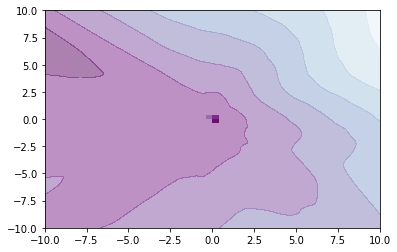

In [27]:
a = 10

x = np.linspace(-a, a, 100)
y = np.linspace(-a, a, 100)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.flatten(), Y.flatten()]).T

generated = gan.generate(10000).data.numpy()
preds = gan.discriminator.forward(torch.FloatTensor(XY)).data.numpy()

xmin, xmax, ymin, ymax = -a, a, -a, a
fig, ax = plt.subplots()
xgen, ygen = generated[:, 0], generated[:, 1]
counts, ybins, xbins, image = ax.hist2d(xgen, ygen, bins=(50, 50), cmap=plt.cm.BuPu, normed=True, range=[[xmin, xmax], [ymin, ymax]])
ax.contourf(X, Y, preds.reshape(X.shape), extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], linewidths=3, cmap=plt.cm.BuPu, alpha=0.5)



In [28]:
def plot_2d_gan(gan, xmin=-10, xmax=10, ymin=-10, ymax=10):
    fig, ax1 = plt.subplots(1, 1, sharey=True)

    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    
    ax1.set_title("2D gan learning")
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.vstack([X.flatten(), Y.flatten()]).T

    generated = gan.generate(10000).data.numpy()
    preds = gan.discriminator.forward(torch.FloatTensor(XY)).data.numpy()
    
    xgen, ygen = generated[:, 0], generated[:, 1]
    counts, ybins, xbins, image = ax1.hist2d(xgen, ygen, bins=(50, 50), cmap=plt.cm.Reds, normed=True, range=[[xmin, xmax], [ymin, ymax]])
    ax1.contourf(X, Y, preds.reshape(X.shape), extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], cmap=plt.cm.BuPu, alpha=0.5) # linewidths=3,

    
    mapped = gan.generator.forward(torch.FloatTensor(XY)).data.numpy()
    #ax2.set_title("Latent mapping")
    
    #counts, ybins, xbins, image = ax.hist2d(X, Y, bins=(50, 50), cmap=plt.cm.BuPu, normed=True, range=[[xmin, xmax], [ymin, ymax]])
        

In [30]:
path = "./visuals/gan_2D_learning_multimodal/{}"

#plot_2d_gan(gan)
#plt.savefig(path.format(0))

# Train and save the progress
for i in range(1000, 2000):
    if not i % 100:
        print("Saved {} plots".format(i + 1))

    vals = gan.train(data, 1, verbose=False) # Train for one update
    plot_2d_gan(gan)
    plt.savefig(path.format(i + 1))
    plt.close()

Saved 1001 plots
Saved 1101 plots
Saved 1201 plots
Saved 1301 plots
Saved 1401 plots
Saved 1501 plots
Saved 1601 plots
Saved 1701 plots
Saved 1801 plots
Saved 1901 plots


In [125]:
%pylab qt

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(xbins[1:], ybins[1:])
Z = counts

my_cols = plt.cm.Reds(counts2/np.max(counts2))

surf = ax.plot_surface(X, Y, Z, facecolors = my_cols,
                       linewidth=0, antialiased=False)
plt.show()

Populating the interactive namespace from numpy and matplotlib


/home/arseny/anaconda3/envs/Deep36_replication/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
